__Steven Raaijmakers (10804242) & Marcus__

In [1]:
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np

__Step 1__

For the first step we had to cut out the original image (bolt2). We achieved this by defining two points on the original image: topleft and bottomright of the cropped image, using the list-slice options we crop the image. After this we use scipy's resize function to resize the image to 128x64. Printing the images shape, we can see it is 4 dimensional, which means it is in RGBA format right now.

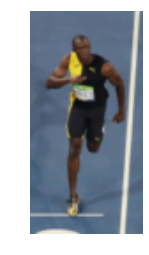

(128, 64, 4)


In [11]:
from scipy.misc import imresize

bolt_full = ndimage.imread("images/bolt2.png")

x1 = 205 ; y1 = 100
x2 = 305 ; y2 = 300
height = 128 ; width = 64

bolt = bolt_full[y1:y2, x1:x2, :]
bolt = imresize(bolt, (height, width))

plt.imshow(bolt)
plt.axis('off')
plt.show()

print(bolt.shape)

__Step 2__

We reduce the original image to an image in grayscale. Printing the shape of the reduce image confirms the image containing only one dimension (containing only grey-values)

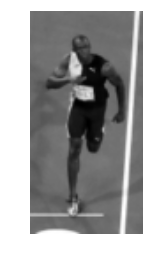

(128, 64)


In [12]:
from skimage import color
bolt_grey = color.rgb2gray(bolt)
plt.imshow(bolt_grey, cmap="gray")
plt.axis('off')
plt.show()

print(bolt_grey.shape)

To calculate the derivatives we use scipy's sobel method. We could have used the kernels in the article, but that would have give the same output. 

In [13]:
from scipy.ndimage import sobel 

def get_derivatives(image):
    gx = sobel(image, axis=0)
    gy = sobel(image, axis=1)
    return gx, gy

For the cart2polar(fx, fy), we use the inverse of tanges to get the angle (toa). After this we make sure the returned angle will be in range 0 to pi. The magnitude can be found by using pythagoras theorem.

In [14]:
def cart2polar(fx, fy):
    angle = np.arctan2(fy, fx)
    angle[angle < 0] += np.pi
    angle[angle > np.pi] %= np.pi
    return np.hypot(fx, fy), angle

To visualize the gradient-components we use our get_derivatives method to obtain the derivatives of our greyscale-bolt-image. Since some of the derivatives are negative we need to make sure to visualize the absolute values of the derivatives. 

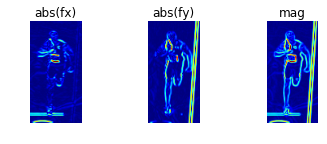

In [15]:
fx, fy = get_derivatives(bolt_grey)
mag, angle = cart2polar(fx, fy)

plt.subplot(2,3,1)
plt.imshow(abs(fx))
plt.axis('off')
plt.title("abs(fx)")

plt.subplot(2,3,2)
plt.imshow(abs(fy))
plt.axis('off')
plt.title("abs(fy)")

plt.subplot(2,3,3)
plt.imshow(mag)
plt.axis('off')
plt.title("mag")

plt.show()

You can see that the abs(fx) shows lines in the x direction (horizontal) while abs(fy) shows lines in the y direction (vertical). The magnitude shows both.

__Step 3__

For the HOG8x8 function we needed to define our bins, which needed to be in range 0 to pi. Every angle > pi needs to be mapped back in the range of 0 to pi.


In [16]:
def HOG8x8(gx, gy):
    bins = np.linspace(0, np.pi, 10)
    mag, angle = cart2polar(gx, gy)
    return np.histogram((angle % np.pi), bins=bins, weights=mag)

In the example below, GX and GY are 8x8 matrices with its derivatives both being 1 (since there are no vars). Therefore the magnitude will be a 8x8 matrix filled with ones. In the histogram this will mean that the height of the bin corresponding to the correct angle will have a height of 8x8x1 = 64.

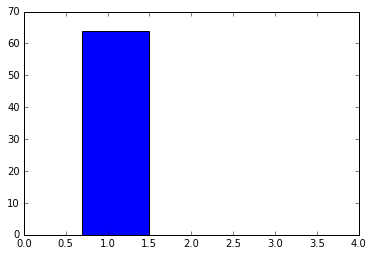

In [17]:
gx = np.ones((8,8)) * np.cos(np.pi / 4)
gy = np.ones((8,8)) * np.sin(np.pi / 4)
h = HOG8x8(gx, gy)

plt.bar(h[1][:-1], h[0])
plt.show()

When different angles are choosen we expect the bin to move completly (heigh 64) to the corresponding bin for that  angle.

__Step 4__

HOGBlock takes 4 histogram, concatenates them and returns the normalizes concatination.

In [18]:
def HOGblock(h1, h2, h3, h4):
    k = np.concatenate((h1, h2, h3, h4))
    norm = np.linalg.norm(k)
    return k / norm

_Feature vector_

For the feature vector we first sliced the original image into smaller 8x8 images.

In [19]:
def make_slices(image, n_width=8, n_height=8):
    im_width = len(image[0]) 
    im_height = len(image)
    
    slices = []    
    for i in range(0, im_height, n_height):
        for j in range(0, im_width, n_width):
            slices.append(image[i:i+n_height, j:j+n_width])
    return slices

 fter the image is sliced we're going to create blocks of images, containing 4 smaller images (aligned with the blue border in the article). When all blocks have a histogram they'll  be concatenated into the large vector.

In [20]:
def create_feature_vector(image, n_width=8, n_height=8):
    im_width = len(image[0]) 
    im_height = len(image)
    
    slices = make_slices(image, n_width, n_height)
            
    # pick correct indices to create all blocks
    len_x = int(im_width / n_width)
    len_y = int(im_height / n_height)
    
    indices = []
    for i in range(len_x * len_y):
        if (i + 1) % n_width == 0:
            continue
    
        p1 = i; p2 = i + 1; p3 = i + len_x; p4 = i + len_x + 1
        
        if p4 > len_x * len_y:
            break
        
        indices.append([p1, p2, p3, p4])
        
    # create feature_vector        
    feature_vector = np.array([])

    for row in indices:
        histos = []
        for column in row:
            fx, fy = get_derivatives(slices[column])
            histos.append(HOG8x8(fx, fy)[0])
        block = HOGblock(histos[0], histos[1], histos[2], histos[3])
        feature_vector = np.concatenate((feature_vector, block))

    return feature_vector

The feature vector should contain 3780 entries:

In [21]:
bolt_feature_vector = create_feature_vector(bolt_grey, 8, 8)

print(bolt_feature_vector.shape)
print(bolt_feature_vector)

(3780,)
[ 0.07245893  0.1215404   0.18136166 ...,  0.00834521  0.00214444
  0.00181097]


__Step 6__

To create the roses we needed to know its center and the corresponding histogram. Since the rose is only in range 0 to pi we need to compute the upper half of a circle. For a rectangular triangle where phi is known and the length of the slanted side is known, we can obtain the coordinates of the end of the slanted side with some basic geometry. 

In [22]:
def rose_lines(center, hist, max_line=5):    
    center_x = center[0]
    center_y = center[1]
    
    lines = []
   
    for i, b in enumerate(hist):
        line_length = (b / max(hist)) * max_line
        phi = (i / (len(hist)) * np.pi)
        
        o = np.sin(phi) * (line_length / 2)
        a = np.cos(phi) * (line_length / 2)
        
        x1 = center_x - a; y1 = center_y - o
        x2 = center_x + a; y2 = center_y + o
        lines.append((x1, y1, x2, y2))
    return lines

In visualize() we're plotting the image, with the roses on their corresponding position.

In [23]:
def visualize(image, n_width=8, n_height=8, figsize=15):
    im_width = len(image[0]) 
    im_height = len(image)
    
    len_x = int(im_width / n_width)
    len_y = int(im_height / n_height)

    all_lines = []
    slices = make_slices(bolt_grey)
    
    # create all roses
    for col in range(0, len_y):
        for row in range(len_x):
            i = col * len_x + row
            gx, gy = get_derivatives(slices[i])
            h, _ = HOG8x8(gx, gy)
            
            x = (row * len_x) + (len_x / 2)
            y = (col * len_x) + (len_x / 2)
            all_lines.append(rose_lines((x, y), h))
            
    # plot image            
    plt.figure(figsize=(figsize, figsize))
    axes = plt.gca()
    axes.set_xlim([0, im_width])
    axes.set_ylim([im_height, 0])
    plt.axis('off')
    plt.imshow(image, cmap="gray")
    
    #plot roses
    for rose in all_lines:
        for (x1, y1, x2, y2) in rose:
            plt.plot([x1, x2], [y1, y2], color='r', linestyle='-', linewidth=1)

    plt.show()

The visualization of the "roses" on bolt_grey seems correct, since most roses are following the borders they're close to. E.g. the roses around the right leg of Bolt demonstrate this. 

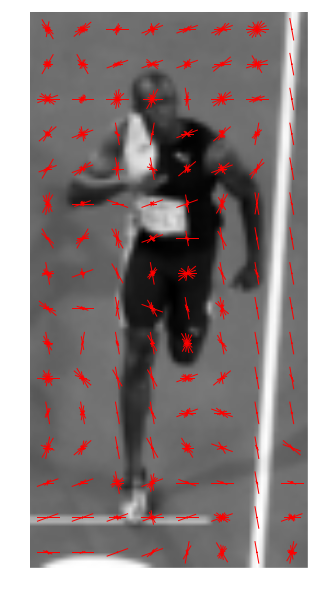

In [24]:
visualize(bolt_grey, figsize=10)